## Training Functions

### Plot graph

In [1]:
import nnfs
import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data, vertical_data

nnfs.init()

def plot_prediction_performance(
    model: list | tuple,
    X, y,
    num_points: int = 100,
    device: str = 'cpu'
) -> None:
    """Plots the performance of the model in the spiral dataset with 3 categories"""
    def probabilities_to_rgb(probabilities_array):
        """ Maps an array of probabilities to RGB colors."""
        # Ensure that probabilities sum up to 1 for all data points
        if not torch.all(torch.isclose(torch.sum(probabilities_array, dim=1), torch.tensor(1.0).to(device))):
            raise ValueError("Probabilities must sum up to 1 for all data points.")
        
        # Map probabilities to RGB channels (0-255) for all data points
        r, g, b = (probabilities_array * 255).to(torch.int32).T
        
        # Return the RGB colors as a torch tensor
        return torch.stack((r, g, b), dim=1)

    # Create a meshgrid of points in the (-1,1)x(-1,1) space
    x_val = torch.linspace(-1, 1, num_points)
    y_val = torch.linspace(-1, 1, num_points)
    x_grid, y_grid = torch.meshgrid(x_val, y_val, indexing='xy')
    
    # Flatten the grids into 1D arrays
    x_flat = x_grid.flatten()
    y_flat = y_grid.flatten()
    
    # Combine the flattened arrays into an Nx2 array
    XX_tuples = torch.stack((x_flat, y_flat), dim=1).to(device)
    
    # Perform a forward pass through the network
    with torch.no_grad():
        model.eval()
        logits = model(XX_tuples)
        probabilities = torch.softmax(logits, dim=1)
    
    rgb_colors = probabilities_to_rgb(probabilities)
    probs_2d = rgb_colors.reshape(num_points, num_points, 3)
    
    # Assumed 3 categories - change this if different
    colors = ['r' if label == 0 else 'g' if label == 1 else 'b' for label in y]
    
    plt.imshow(probs_2d.cpu().numpy(), extent=(-1, 1, -1, 1), interpolation='bilinear')
    plt.scatter(X[:, 0].cpu(), -X[:, 1].cpu(), c=colors)
    plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize

def plot_evolution(w_C, w_A, window_size=20):
    # smooth the data with a moving average
    w_C = np.convolve(w_C, np.ones(window_size), 'valid') / window_size
    w_A = np.convolve(w_A, np.ones(window_size), 'valid') / window_size
    
    time = np.linspace(0, 1, len(w_A))

    # Create segments for the line
    points = np.array([w_A, w_C]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a line collection
    norm = Normalize(vmin=time.min(), vmax=time.max())  # Normalize time values
    lc = LineCollection(segments, cmap="viridis", norm=norm)
    lc.set_array(time)  # Use time to color the line

    # Create the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.add_collection(lc)
    ax.autoscale()  # Adjust axis limits
    ax.set_xlabel("W_A")
    ax.set_ylabel("W_C")
    ax.set_title("Final result: {:.3f}".format(w_C[-1]))
    ax.grid(True)

    # Add a colorbar to show time progression
    cbar = plt.colorbar(lc, ax=ax)
    cbar.set_label("Time")

    # plot initial and final points
    plt.scatter(w_A[0], w_C[0], c='r', label='Initial')
    plt.scatter(w_A[-1], w_C[-1], c='g', label='Final')

    plt.show()

## SHD

In [3]:
from torch.optim import Optimizer

class SHD(Optimizer):
    
    def __init__(self, param_groups, lr=0.01, weight_decay=0.1, t=[1]):
        defaults = dict(lr=lr, weight_decay=weight_decay, t=t)
        super(SHD, self).__init__(param_groups, defaults)
        self.t = []
        self.counter = 1

        layer_counter = 0
        previous_num_rows = 0
        group_C = param_groups[0]
        t = group_C['t']
        for param in group_C['params']:
            if len(param.data.shape) == 1:
                self.t.append(t[layer_counter-1] * previous_num_rows)
            else:
                self.t.append(t[layer_counter])
                previous_num_rows = param.data.shape[1]
                layer_counter += 1
        
        self.learning_rate_C = param_groups[0]['lr']
        self.weight_decay_C = param_groups[0]['weight_decay']
        self.learning_rate_A = param_groups[1]['lr']
        self.weight_decay_A = param_groups[1]['weight_decay']
            

    def step(self):
        # Update each parameter
        for param_C, param_A, t in zip(self.param_groups[0]['params'], self.param_groups[1]['params'], self.t):
            if param_C.grad is None:
                continue
            self.update_A(param_C, param_A)

            # update params of C matrix
            if self.counter % t == 0:
                if len(param_C.data.shape) == 1:
                    update_index = -1
                else:
                    update_index = (self.counter // t) % param_C.data.shape[1]
                self.update_C(param_C, param_A, update_index)
        self.counter += 1

    
    def update_A(self, layer_C, layer_A):
        # update the weights of the Auxiliary matrix with the gradients of C and weight decay
        layer_A.data += -self.learning_rate_A * (layer_C.grad + self.weight_decay_A * layer_A.data * torch.abs(layer_C.grad))

    def update_C(self, layer_C, layer_A, update_index):
        if update_index == -1:
            layer_C.data += self.learning_rate_C * (layer_A.data - self.weight_decay_C * layer_C.data * torch.abs(layer_A.data))
        else:
            layer_C.data[:, update_index] += self.learning_rate_C * (layer_A.data[:, update_index] - self.weight_decay_C * layer_C.data[:, update_index] * torch.abs(layer_A.data[:, update_index]))


In [3]:
import torch
import torch.nn as nn

# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu'):
        super(Network, self).__init__()
        self.l1_C = nn.Linear(1, 1, bias=False).to(device)
        self.l1_A = nn.Linear(1, 1, bias=False).to(device)

        # Initialize the weights of the A matrix to 0
        self.l1_A.weight.data.fill_(0)
        for param in self.l1_A.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.l1_C(x)
        return x

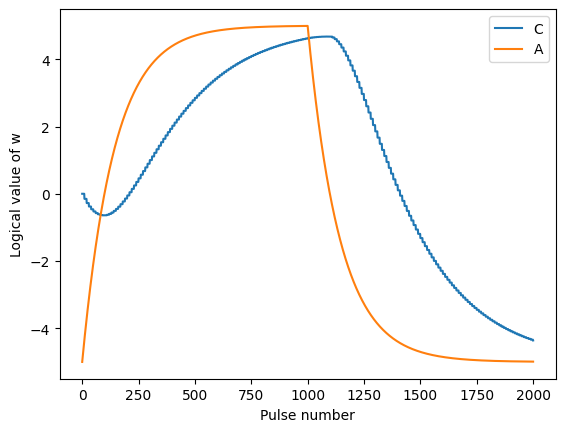

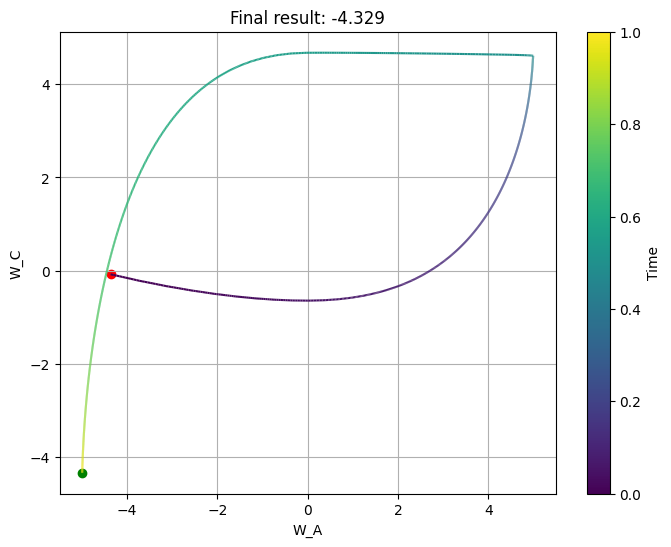

In [5]:
model = Network()

optimizer = SHD([
    {'params': model.l1_C.parameters(), 'lr': 0.035, 'weight_decay': 0.2, 't': [10]},
    {'params': model.l1_A.parameters(), 'lr': 0.035, 'weight_decay': 0.2},
])


model.l1_A.weight.data = torch.tensor([[-1/0.2]])
model.l1_C.weight.data = torch.tensor([[0.0]])

w_C = [model.l1_C.weight.item()]
w_A = [model.l1_A.weight.item()]

for i in range(2000):
    if i < 1000:
        model(torch.tensor([[1.0]]))
        model.l1_C.weight.grad = torch.tensor([[-1.0]])

    else:
        model(torch.tensor([[1.0]]))
        model.l1_C.weight.grad = torch.tensor([[1.0]])

    optimizer.step()
    optimizer.zero_grad()
    w_C.append(model.l1_C.weight.item())
    w_A.append(model.l1_A.weight.item())

plt.plot(w_C, label='C')
plt.plot(w_A, label='A')
plt.xlabel('Pulse number')
plt.ylabel('Logical value of w')
plt.legend()
plot_evolution(w_C, w_A)

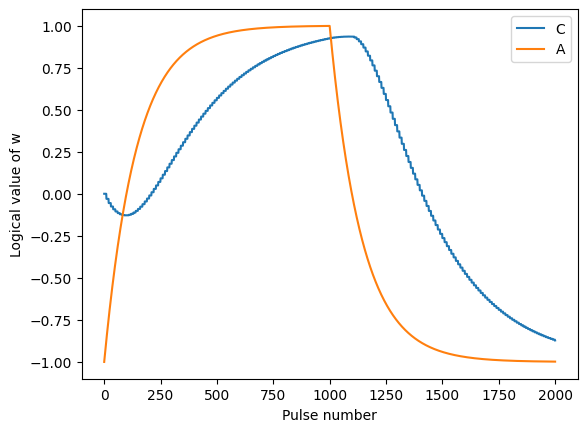

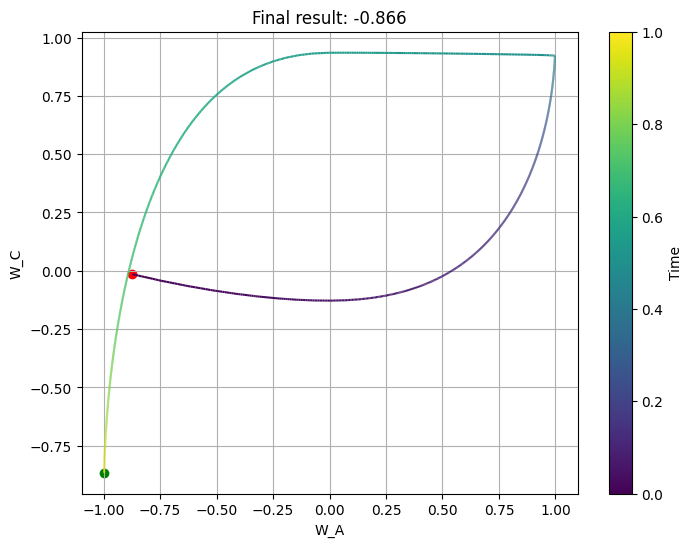

In [6]:
model = Network()

optimizer = SHD([
    {'params': model.l1_C.parameters(), 'lr': 0.035, 'weight_decay': 1, 't': [10]},
    {'params': model.l1_A.parameters(), 'lr': 0.007, 'weight_decay': 1},
])

model.l1_A.weight.data = torch.tensor([[-1/1]])
model.l1_C.weight.data = torch.tensor([[0.0]])

w_C = [model.l1_C.weight.item()]
w_A = [model.l1_A.weight.item()]
for i in range(2000):
    if i < 1000:
        # model(torch.tensor([[1.0]]))
        # model.l1_C.weight.grad = torch.tensor([[-1.0]])

        y = model(torch.tensor([[1.0]]))
        l = (1 - y)

    else:
        # model(torch.tensor([[1.0]]))
        # model.l1_C.weight.grad = torch.tensor([[1.0]])

        y = model(torch.tensor([[1.0]]))
        l = y

    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    w_C.append(model.l1_C.weight.item())
    w_A.append(model.l1_A.weight.item())

plt.plot(w_C, label='C')
plt.plot(w_A, label='A')
plt.xlabel('Pulse number')
plt.ylabel('Logical value of w')
plt.legend()
plot_evolution(w_C, w_A)

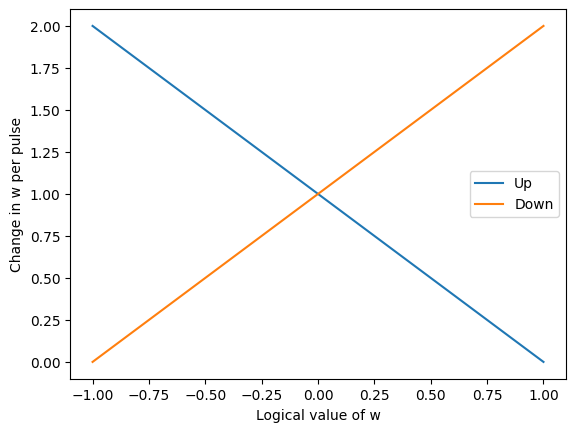

In [7]:
# for a seuqnece of points of values between -1 and 1 for conductance,
# get the resulting value for the update
model = Network()

optimizer = SHD([
    {'params': model.l1_C.parameters(), 'lr': 1, 'weight_decay': 1, 't': [1]},
    {'params': model.l1_A.parameters(), 'lr': 1, 'weight_decay': 1},
])

conductance = torch.linspace(-1, 1, 1000)
up_result = []
down_result = []

for c in conductance:
    model.l1_A.weight.data = torch.tensor([[c]])
    out = model(torch.tensor([[1.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    down_result.append(c - model.l1_A.weight.item())

for c in conductance:
    model.l1_A.weight.data = torch.tensor([[c]])
    out = model(torch.tensor([[-1.0]]))
    out.backward()
    optimizer.step()
    optimizer.zero_grad()
    up_result.append(model.l1_A.weight.item() - c)

plt.plot(conductance, up_result, label='Up')
plt.plot(conductance, down_result, label='Down')
plt.xlabel('Logical value of w')
plt.ylabel('Change in w per pulse')
plt.legend()

## Training

In [9]:
def training_run(X, y, model, optimizer, loss_fn, epochs, batch_size=1):
    loss = []
    accuracy = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    neuron = 0
    weight = 0
    w_C = [model.C.l1.weight[neuron][weight].item()]
    w_A = [model.A.l1.weight[neuron][weight].item()]

    # batch the data
    X = torch.split(X, batch_size)
    y = torch.split(y, batch_size)
    
    for _ in range(epochs):
        epoch_loss = []
        epoch_accuracy = []
        for x, y_true in zip(X, y):
            output = model(x)
            l = loss_fn(output, y_true)
            epoch_loss.append(l.item())

            # accuracy if loss is crossentropy
            if isinstance(loss_fn, nn.CrossEntropyLoss):
                correct_predictions = torch.sum(torch.argmax(output, axis=1) == y_true)
                epoch_accuracy.append(correct_predictions.item() / len(y_true))

            # backward pass
            l.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            w_C.append(model.C.l1.weight[neuron][weight].item())
            w_A.append(model.A.l1.weight[neuron][weight].item())


        loss.append(np.mean(epoch_loss))
        if epoch_accuracy != []:
            accuracy.append(np.mean(epoch_accuracy))

    return loss, accuracy, w_C, w_A


### Spiral_data

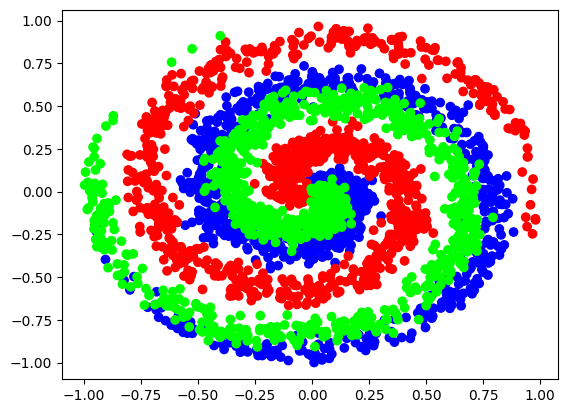

In [5]:
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)

# plot spiral data
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [7]:
class C_A_Network_spiral(nn.Module):
    
    class Network(nn.Module):
        def __init__(self, zeroes=False, device='cpu'):
            super(C_A_Network_spiral.Network, self).__init__()
            self.l1 = nn.Linear(2, 64).to(device)
            self.l2 = nn.Linear(64, 3).to(device)

            if zeroes:
                self.l1.weight.data.fill_(0)
                self.l2.weight.data.fill_(0)
                for param in self.l1.parameters():
                    param.requires_grad = False
                for param in self.l2.parameters():
                    param.requires_grad = False
            
            else:
                self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.01
                self.l2.weight.data = torch.randn_like(self.l2.weight.data) * 0.01

            self.l1.bias.data.fill_(0)
            self.l2.bias.data.fill_(0)
        
        def forward(self, x):
            x = torch.relu(self.l1(x)) #* 10
            x = self.l2(x) #* 10
            return x * 25


    def __init__(self, device='cpu'):
        super(C_A_Network_spiral, self).__init__()
        self.C = self.Network(zeroes=False, device=device)
        self.A = self.Network(zeroes=True, device=device)    

    def forward(self, x):
        return self.C(x)

#### Grid search

In [33]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1e-2, 5e-2, 1e-1]
learning_rate_A = [1e-2, 5e-2, 1e-1]
t = [[1, 1], [5, 1]]

best_loss = float('inf')
best_accuracy = 0
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                model = C_A_Network_spiral().to(device)
                optimizer = SHD([
                    {'params': model.C.parameters(), 'lr': lr_C, 'weight_decay': 0.2, 't': t_},
                    {'params': model.A.parameters(), 'lr': lr_A, 'weight_decay': 0.2},
                ])
                loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 1000, batch_size=32)
                loss = np.mean(loss[-100:])
                accuracy = np.mean(accuracy[-100:])
                print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': loss,
                    'accuracy': accuracy,
                })
                if loss < best_loss:
                    best_loss = loss
                    best_accuracy = accuracy
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 0.60, accuracy: 0.72 for params: lr_C: 0.01, lr_A: 0.01, t: [1, 1]
Loss: 0.75, accuracy: 0.63 for params: lr_C: 0.01, lr_A: 0.01, t: [5, 1]
Loss: 0.75, accuracy: 0.63 for params: lr_C: 0.01, lr_A: 0.05, t: [1, 1]
Loss: 0.50, accuracy: 0.79 for params: lr_C: 0.01, lr_A: 0.05, t: [5, 1]
Loss: 0.46, accuracy: 0.80 for params: lr_C: 0.01, lr_A: 0.1, t: [1, 1]
Loss: 0.54, accuracy: 0.78 for params: lr_C: 0.01, lr_A: 0.1, t: [5, 1]
Loss: 0.52, accuracy: 0.76 for params: lr_C: 0.05, lr_A: 0.01, t: [1, 1]
Loss: 0.88, accuracy: 0.51 for params: lr_C: 0.05, lr_A: 0.01, t: [5, 1]
Loss: 0.43, accuracy: 0.83 for params: lr_C: 0.05, lr_A: 0.05, t: [1, 1]
Loss: 0.39, accuracy: 0.85 for params: lr_C: 0.05, lr_A: 0.05, t: [5, 1]
Loss: 0.48, accuracy: 0.80 for params: lr_C: 0.05, lr_A: 0.1, t: [1, 1]
Loss: 0.41, accuracy: 0.84 for params: lr_C: 0.05, lr_A: 0.1, t: [5, 1]
Loss: 0.40, accuracy: 0.85 for params: lr_C: 0.1, lr_A: 0.01, t: [1, 1]
Loss: 0.81, accuracy: 0.55 for params: lr_C: 0.1, lr_A: 

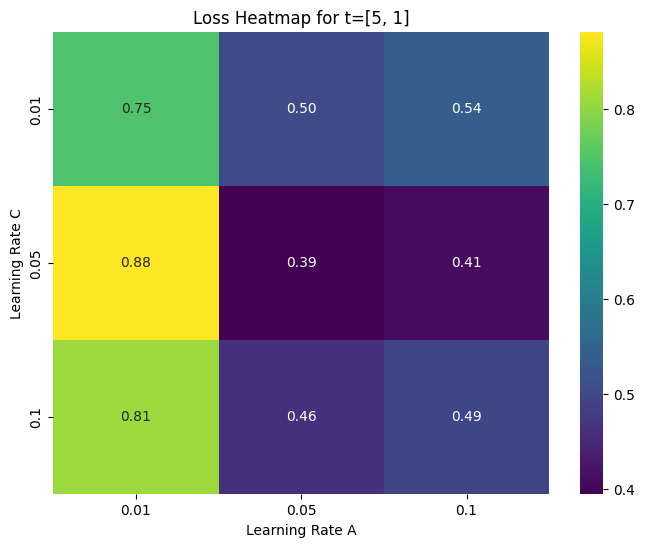

In [35]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [5, 1]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="loss")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

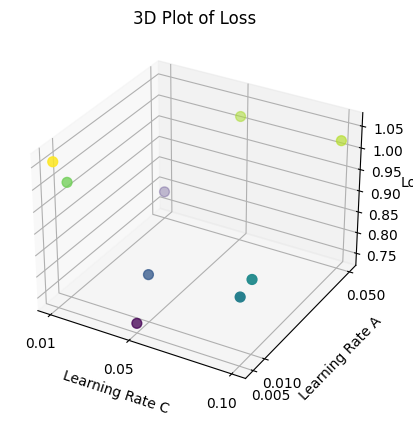

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Prepare data for 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract values
x = df['lr_C']
y = df['lr_A']
z = df['loss']

# Plot
ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
ax.set_xlabel("Learning Rate C")
ax.set_ylabel("Learning Rate A")
ax.set_zlabel("Loss")
ax.set_xticks(learning_rate_C)
ax.set_yticks(learning_rate_A)
plt.title("3D Plot of Loss")
plt.show()

#### Run

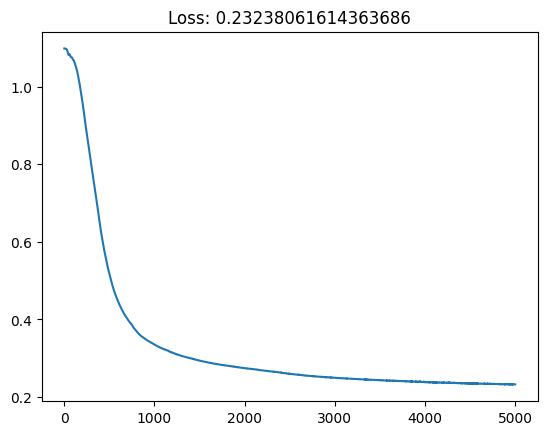

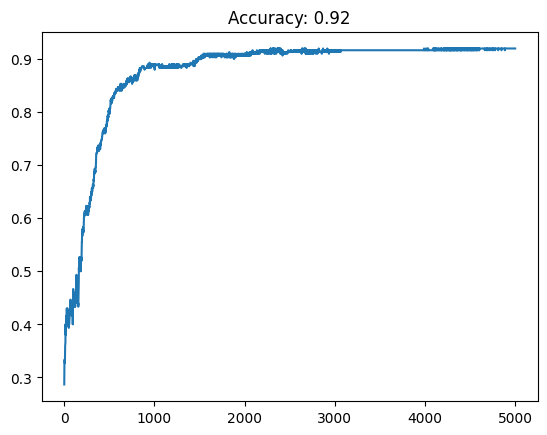

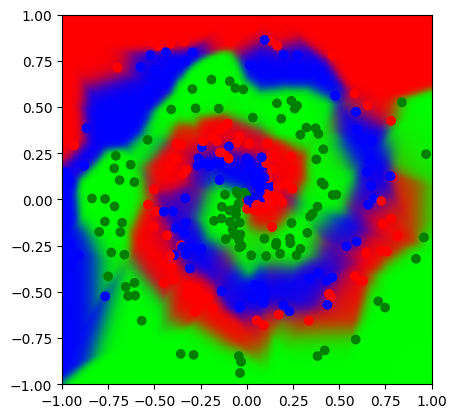

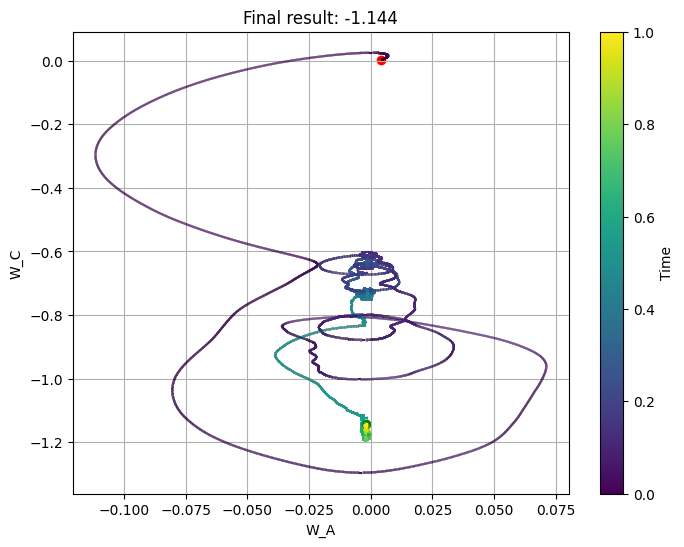

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.01, 'weight_decay': 0.2, 't': [10, 1]},
    {'params': model.A.parameters(), 'lr': 0.01, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 5000, batch_size=1)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=10000)

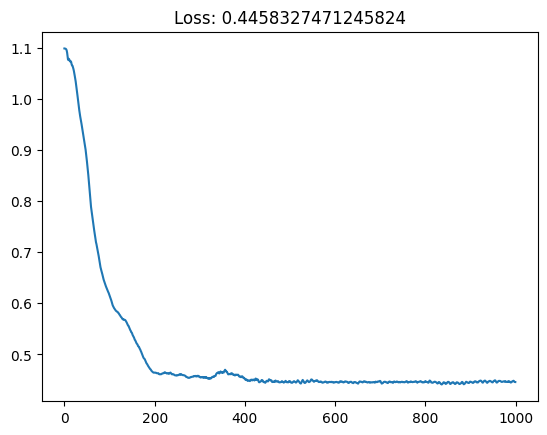

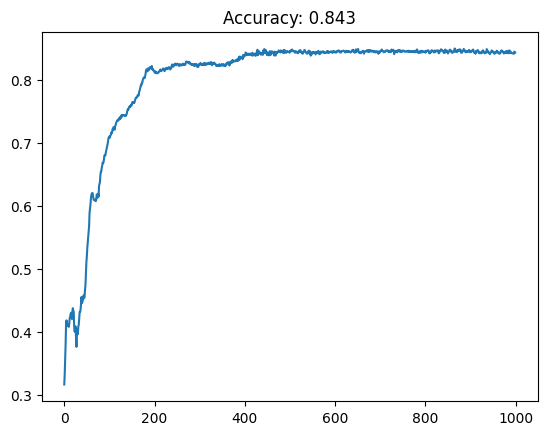

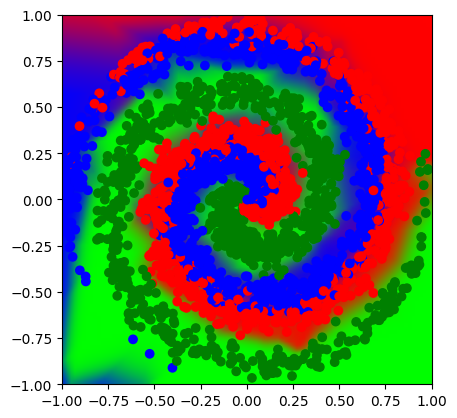

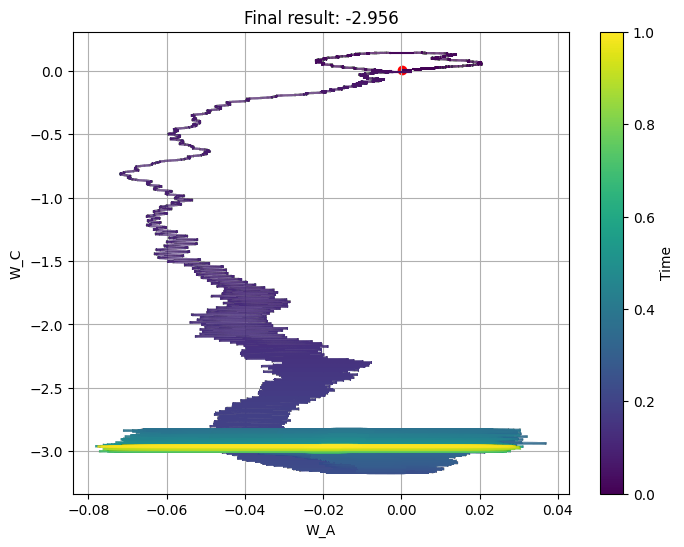

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.005, 'weight_decay': 0.2, 't': [10, 1]},
    {'params': model.A.parameters(), 'lr': 0.005, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=1)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=1000)

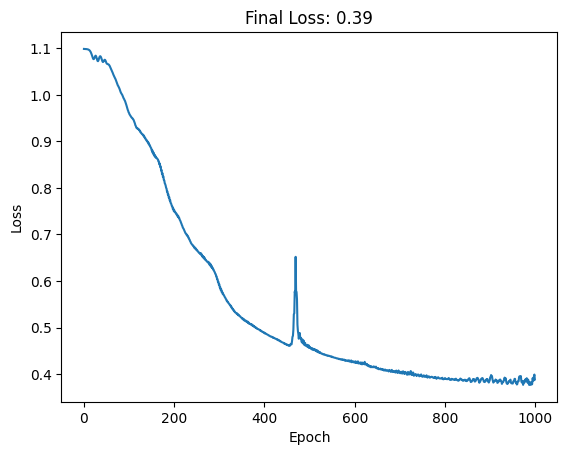

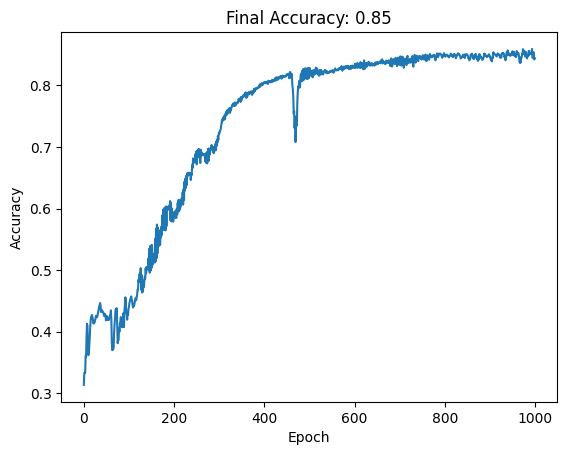

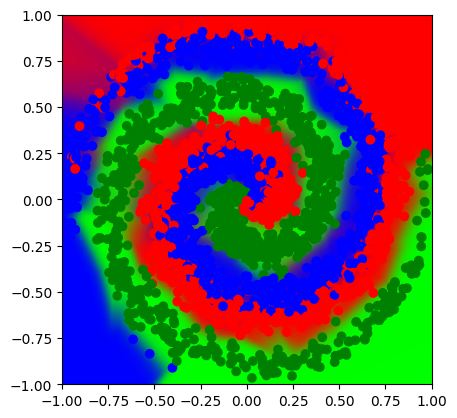

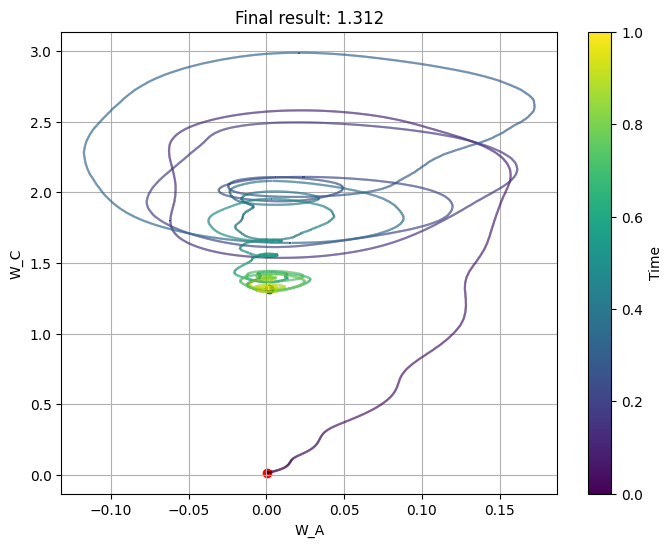

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.05, 'weight_decay': 0.2, 't': [5, 1]},
    {'params': model.A.parameters(), 'lr': 0.05, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=32)

plt.plot(loss)
plt.title(f'Final Loss: {np.mean(loss[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracy)
plt.title(f'Final Accuracy: {np.mean(accuracy[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=1000)

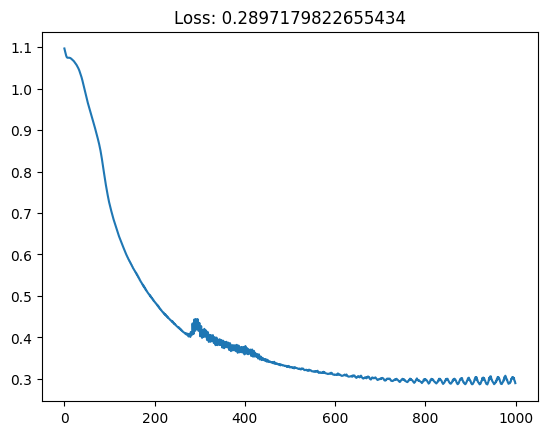

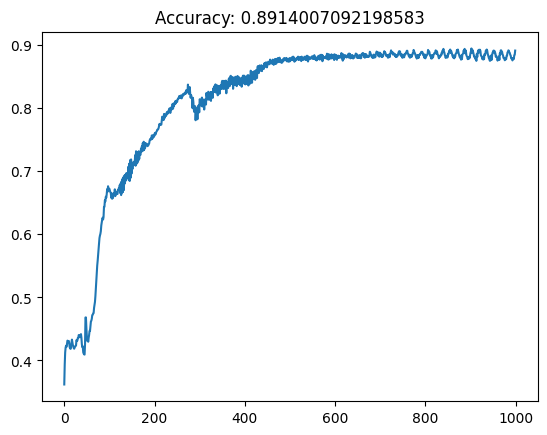

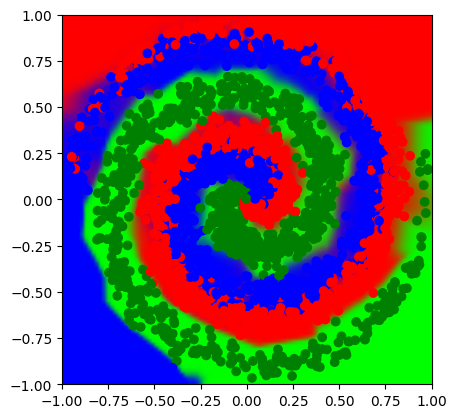

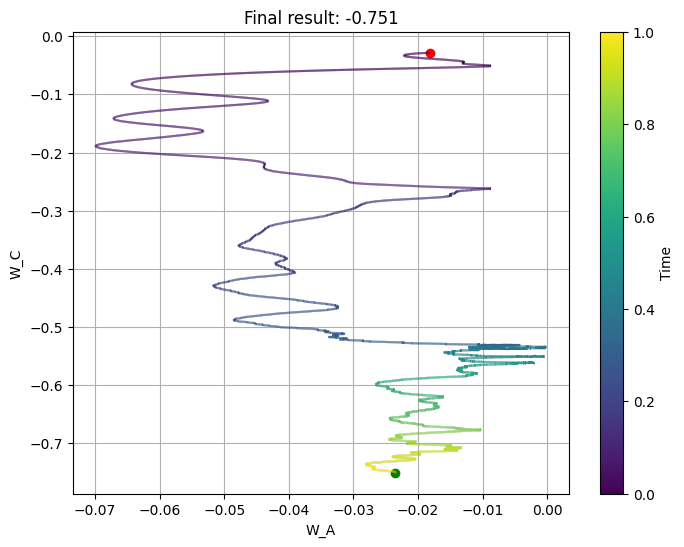

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.007, 'weight_decay': 1, 't': [5, 1]},
    {'params': model.A.parameters(), 'lr': 0.007, 'weight_decay': 1},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=32)

plt.plot(loss)
plt.title(f'Final Loss: {np.mean(loss[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracy)
plt.title(f'Final Accuracy: {np.mean(accuracy[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=1000)

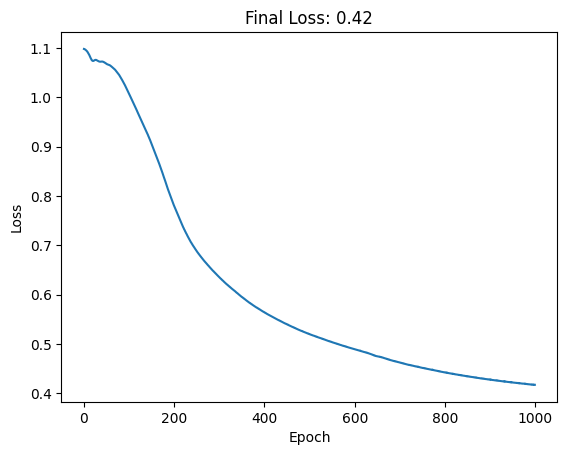

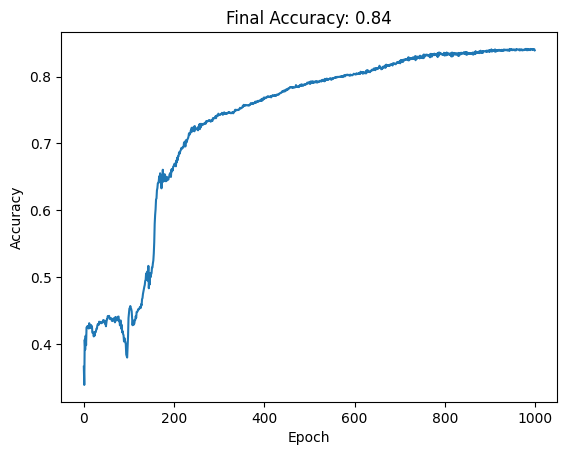

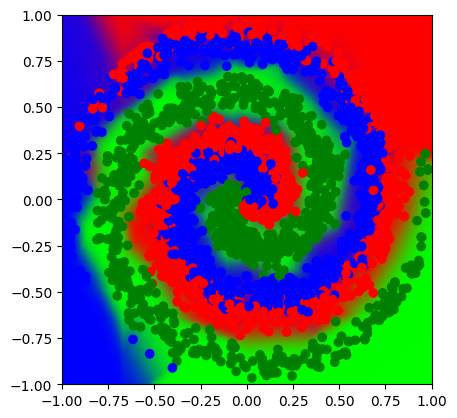

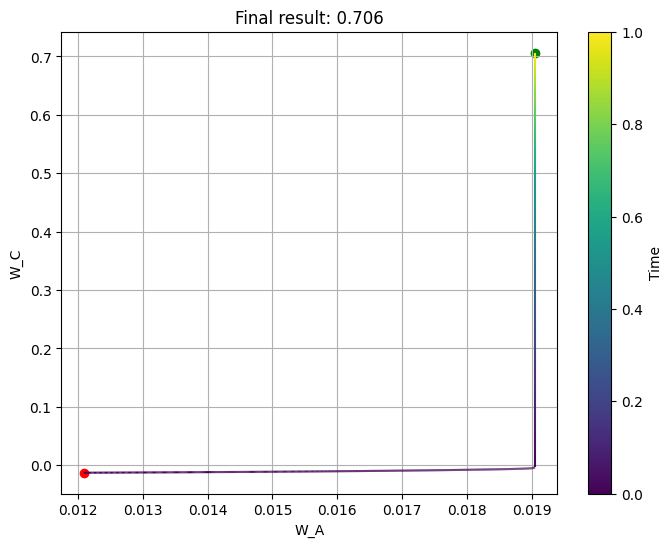

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.007, 'weight_decay': 1, 't': [5, 1]},
    {'params': model.A.parameters(), 'lr': 0.007, 'weight_decay': 1},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=32)

plt.plot(loss)
plt.title(f'Final Loss: {np.mean(loss[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracy)
plt.title(f'Final Accuracy: {np.mean(accuracy[-50:]):.2f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=1000)

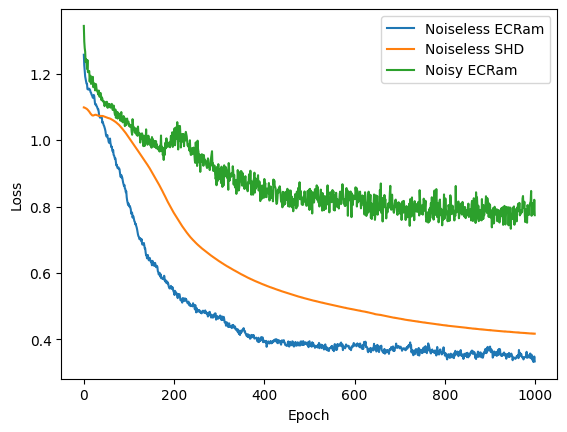

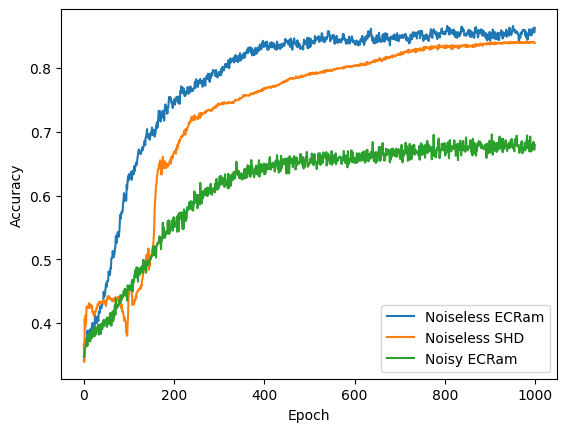

In [41]:
# load loss.py and accuracy.py
loss_a = np.load('loss.npy')
accuracy_a = np.load('accuracy.npy')
loss_n = np.load('loss_n.npy')
accuracy_n = np.load('accuracy_n.npy')

plt.plot(loss_a, label='Noiseless ECRam')
plt.plot(loss, label='Noiseless SHD')
plt.plot(loss_n, label='Noisy ECRam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(accuracy_a, label='Noiseless ECRam')
plt.plot(accuracy, label='Noiseless SHD')
plt.plot(accuracy_n, label='Noisy ECRam')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [35]:
input = X[6]
l1 =  model.C.l1.weight.data @ input + model.C.l1.bias.data
l2 = model.C.l2.weight.data @ torch.relu(l1) + model.C.l2.bias.data
print(l2) 

tensor([-0.1286,  0.4549,  0.0052])


In [36]:
model(X[:100])

tensor([[ 0.1681,  0.6445,  0.3069],
        [ 0.2257,  0.3537,  0.1992],
        [ 0.2393,  0.4660,  0.1233],
        [ 0.3122,  0.7197,  0.1554],
        [ 0.2821,  1.5141,  0.4701],
        [ 0.3455,  0.5055,  0.3592],
        [-0.1286,  0.4549,  0.0052],
        [ 0.3933,  1.2556,  1.7266],
        [ 0.1395, -0.3575,  0.2655],
        [ 0.5240,  0.4810,  0.3956],
        [ 0.6191,  1.0002,  0.9198],
        [ 0.4494, -0.3699,  0.3809],
        [ 0.3797,  0.5242,  0.3924],
        [ 0.4152,  1.2289,  1.7714],
        [-0.0588,  0.0366,  0.0945],
        [-0.4879,  0.6796, -1.4238],
        [ 0.5623,  0.8225,  0.6777],
        [ 0.8111,  0.6878,  0.7813],
        [ 1.5140, -0.3018,  1.4559],
        [ 0.3536, -0.0064,  0.3512],
        [ 0.4004, -0.4710,  0.3509],
        [ 1.4778, -0.0887,  1.6601],
        [-0.1099,  0.4338,  0.0077],
        [ 0.2594,  0.4834,  0.2884],
        [ 0.3463,  0.5099,  0.3620],
        [ 0.4226, -0.4071,  0.3740],
        [ 0.6684, -0.3470,  0.4669],
 

In [30]:
input = X[0]
l1 = model.C.l1.weight.data/5 @ input + model.C.l1.bias.data/5
l2 = model.C.l2.weight.data/5 @ torch.relu(l1) + model.C.l2.bias.data/25
print(l2*25) 

tensor([0.1681, 0.6445, 0.3069])


### Vertical_data

In [70]:
class C_A_Network_vertical(nn.Module):
    
    class Network(nn.Module):
        def __init__(self, zeroes=False, device='cpu'):
            super(C_A_Network_vertical.Network, self).__init__()
            self.l1 = nn.Linear(2, 16).to(device)
            self.l2 = nn.Linear(16, 3).to(device)

            if zeroes:
                self.l1.weight.data.fill_(0)
                self.l2.weight.data.fill_(0)
                for param in self.l1.parameters():
                    param.requires_grad = False
                for param in self.l2.parameters():
                    param.requires_grad = False
            
            else:
                self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.01
                self.l2.weight.data = torch.randn_like(self.l2.weight.data) * 0.01

            self.l1.bias.data.fill_(0)
            self.l2.bias.data.fill_(0)
        
        def forward(self, x):
            x = torch.relu(self.l1(x))
            x = self.l2(x)
            return x


    def __init__(self, device='cpu'):
        super(C_A_Network_vertical, self).__init__()
        self.C = self.Network(zeroes=False, device=device)
        self.A = self.Network(zeroes=True, device=device)    

    def forward(self, x):
        return self.C(x)

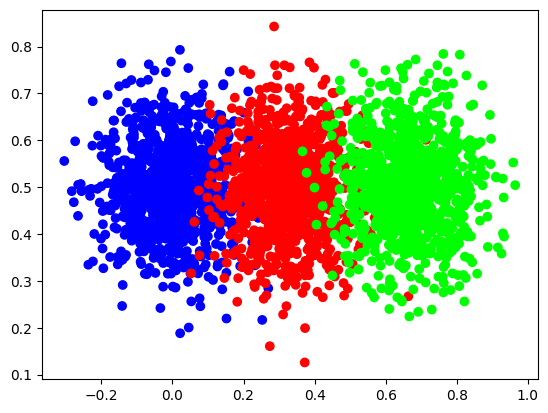

In [71]:
X_np, y_np = vertical_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32)
y = torch.tensor(y_np, dtype=torch.int32)

# plot the spiral dataset
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap='brg')

In [256]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

# grid search
learning_rate_C = [1e-3, 1e-2, 1e-1]
learning_rate_A = [1e-3, 1e-2, 1e-1]
t = [[1, 1],[5, 1]]

best_loss = float('inf')
best_accuracy = 0

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                model = C_A_Network_vertical().to(device)
                optimizer = SHD([
                    {'params': model.C.parameters(), 'lr': lr_C, 'weight_decay': 0.2, 't': t_},
                    {'params': model.A.parameters(), 'lr': lr_A, 'weight_decay': 0.2},
                ])
                loss, accuracy, _, _ = training_run(X, y, model, optimizer, nn.CrossEntropyLoss(), 20)
                print(f'Loss: {loss[-1]:.2f}, accuracy: {accuracy[-1]:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_accuracy = accuracy[-1]
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

Loss: 1.10, accuracy: 0.33 for params: lr_C: 0.001, lr_A: 0.001, t: [1, 1]
Loss: 1.10, accuracy: 0.33 for params: lr_C: 0.001, lr_A: 0.001, t: [5, 1]
Loss: 1.07, accuracy: 0.47 for params: lr_C: 0.001, lr_A: 0.01, t: [1, 1]
Loss: 1.10, accuracy: 0.33 for params: lr_C: 0.001, lr_A: 0.01, t: [5, 1]
Loss: 0.36, accuracy: 0.90 for params: lr_C: 0.001, lr_A: 0.1, t: [1, 1]
Loss: 0.93, accuracy: 0.60 for params: lr_C: 0.001, lr_A: 0.1, t: [5, 1]
Loss: 1.11, accuracy: 0.06 for params: lr_C: 0.01, lr_A: 0.001, t: [1, 1]
Loss: 1.11, accuracy: 0.31 for params: lr_C: 0.01, lr_A: 0.001, t: [5, 1]
Loss: 0.22, accuracy: 0.92 for params: lr_C: 0.01, lr_A: 0.01, t: [1, 1]
Loss: 0.56, accuracy: 0.85 for params: lr_C: 0.01, lr_A: 0.01, t: [5, 1]
Loss: 0.50, accuracy: 0.79 for params: lr_C: 0.01, lr_A: 0.1, t: [1, 1]
Loss: 0.34, accuracy: 0.87 for params: lr_C: 0.01, lr_A: 0.1, t: [5, 1]
Loss: 0.23, accuracy: 0.92 for params: lr_C: 0.1, lr_A: 0.001, t: [1, 1]
Loss: 0.70, accuracy: 0.77 for params: lr_C: 

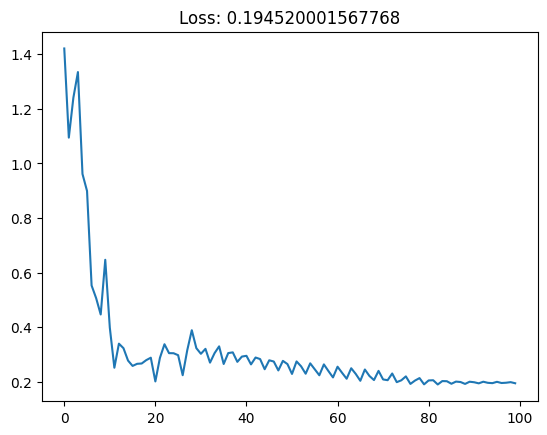

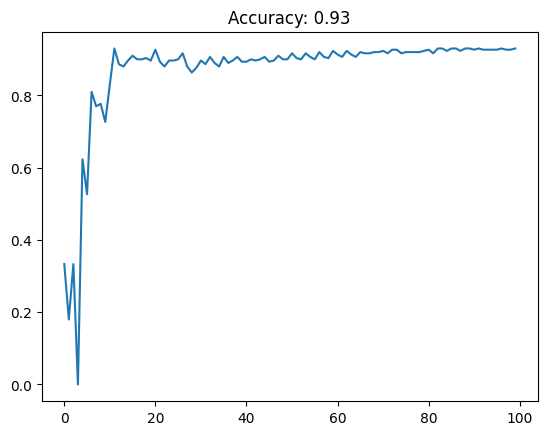

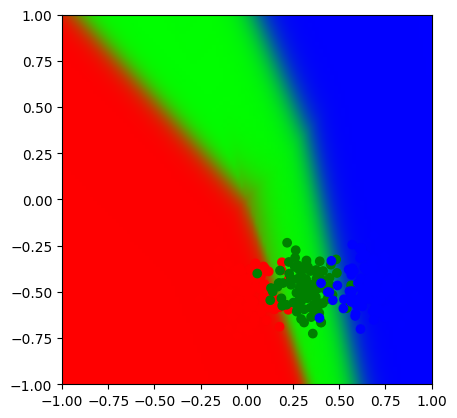

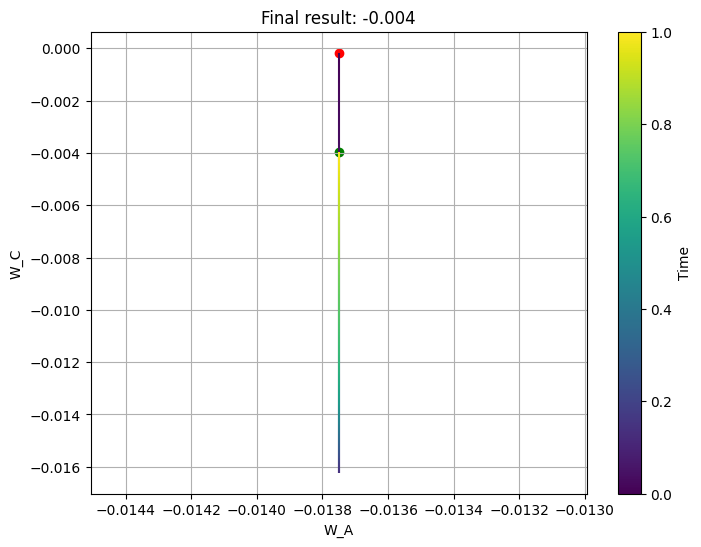

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = vertical_data(samples=100, classes=3)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)

model = C_A_Network_vertical().to(device)
optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 0.1, 'weight_decay': 0.2, 't': [5,1]},
    {'params': model.A.parameters(), 'lr': 0.01, 'weight_decay': 0.2},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 100, batch_size=1)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)
plot_evolution(w_A, w_C, window_size=1000)

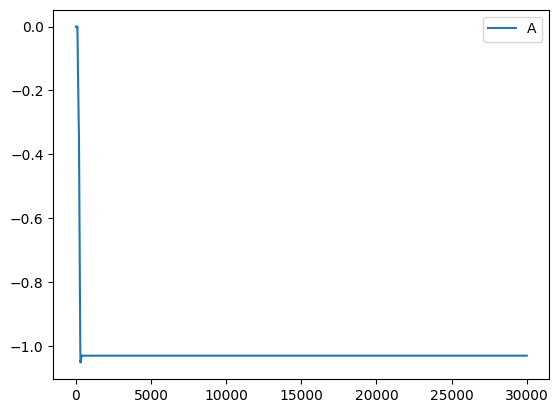

In [224]:
plt.plot(w_A, label='A')
#plt.plot(w_C, label='C')
plt.legend()

### Synthetic data -> regression

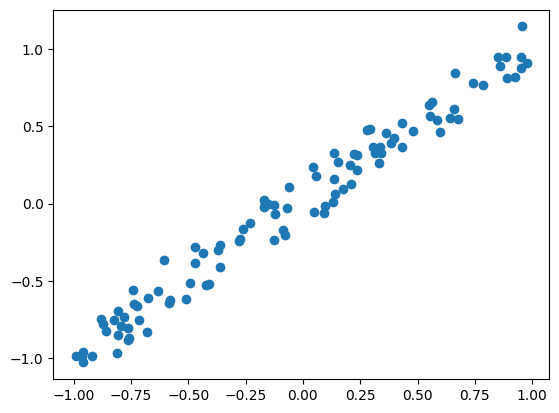

In [12]:
# generate a 100 point dataset for a linear regression problem with 1 feature
def generate_linear_regression_data(num_points=100):
    X = np.random.uniform(-1, 1, (num_points, 1))
    y = 1 * X + np.random.normal(0, 0.1, (num_points, 1))
    return X, y

# plot the data
X, y = generate_linear_regression_data(100)
plt.scatter(X, y)

In [13]:
class C_A_Network_linear(nn.Module):

    class Network(nn.Module):
        def __init__(self, zeroes=False, device='cpu'):
            super(C_A_Network_linear.Network, self).__init__()
            self.l1 = nn.Linear(1, 1, bias=False).to(device)

            if zeroes:
                self.l1.weight.data.fill_(0)
                for param in self.l1.parameters():
                    param.requires_grad = False
            
            else:
                self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.01
        
        def forward(self, x):
            x = self.l1(x)
            return x
    
    def __init__(self, device='cpu'):
        super(C_A_Network_linear, self).__init__()
        self.C = self.Network(zeroes=False, device=device)
        self.A = self.Network(zeroes=True, device=device)

    def forward(self, x):
        return self.C(x)

In [17]:
# grid search for hyperparameters
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

# grid search
learning_rate_C = [5e-4, 1e-3, 5e-3]
learning_rate_A = [1e-1, 5e-1, 1]
t = [[5], [10], [20]]

best_loss = float('inf')

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                model = C_A_Network_linear().to(device)
                optimizer = SHD([
                    {'params': model.C.parameters(), 'lr': lr_C, 'weight_decay': 0.2, 't': t_},
                    {'params': model.A.parameters(), 'lr': lr_A, 'weight_decay': 0.2},
                ])
                loss, _, _, _ = training_run(X, y, model, optimizer, nn.MSELoss(), 20)
                print(f'Loss: {loss[-1]:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                if loss[-1] < best_loss:
                    best_loss = loss[-1]
                    best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

print(f'Best loss: {best_loss} for params: {best_params}')

Loss: 0.01 for params: lr_C: 0.0005, lr_A: 0.1, t: [5]
Loss: 0.10 for params: lr_C: 0.0005, lr_A: 0.1, t: [10]
Loss: 0.21 for params: lr_C: 0.0005, lr_A: 0.1, t: [20]
Loss: 0.01 for params: lr_C: 0.0005, lr_A: 0.5, t: [5]
Loss: 0.10 for params: lr_C: 0.0005, lr_A: 0.5, t: [10]
Loss: 0.20 for params: lr_C: 0.0005, lr_A: 0.5, t: [20]
Loss: 0.01 for params: lr_C: 0.0005, lr_A: 1, t: [5]
Loss: 0.11 for params: lr_C: 0.0005, lr_A: 1, t: [10]
Loss: 0.20 for params: lr_C: 0.0005, lr_A: 1, t: [20]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.1, t: [5]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.1, t: [10]
Loss: 0.11 for params: lr_C: 0.001, lr_A: 0.1, t: [20]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.5, t: [5]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 0.5, t: [10]
Loss: 0.11 for params: lr_C: 0.001, lr_A: 0.5, t: [20]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 1, t: [5]
Loss: 0.01 for params: lr_C: 0.001, lr_A: 1, t: [10]
Loss: 0.10 for params: lr_C: 0.001, lr_A: 1, t: [20]
Loss: 0.01 for para

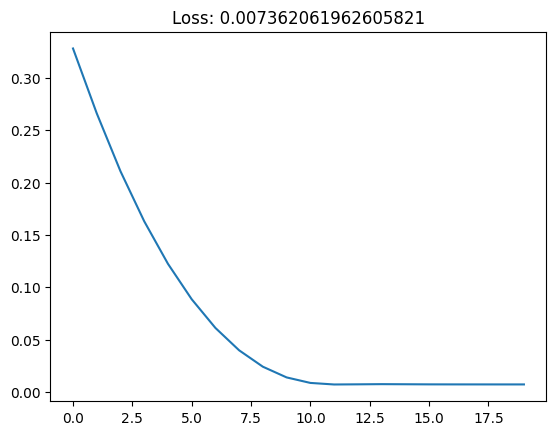

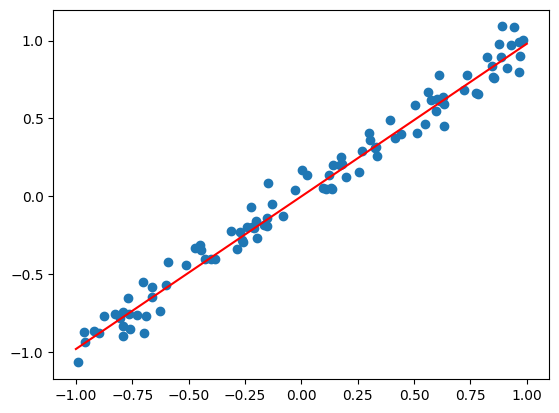

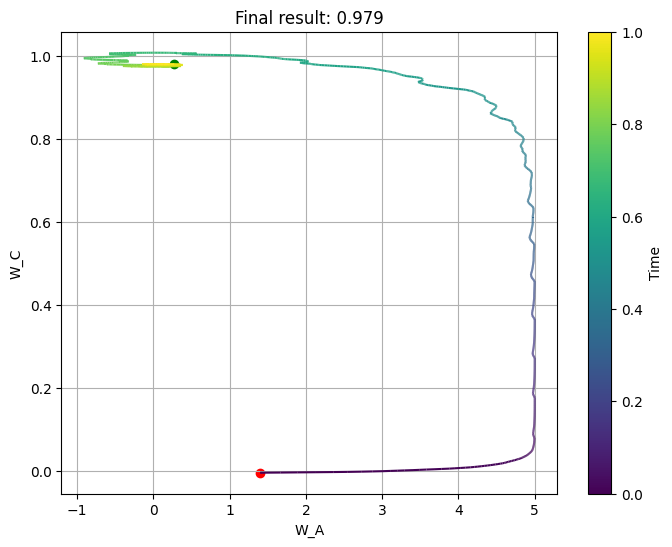

In [18]:
device = 'cpu'
X_np, y_np = generate_linear_regression_data(100)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.float32).to(device)

model = C_A_Network_linear().to(device)
optimizer = SHD([
    {'params': model.C.parameters(), 'lr': 1e-3, 'weight_decay': 0.2, 't': [5]},
    {'params': model.A.parameters(), 'lr': 5e-1, 'weight_decay': 0.2},
])


loss_fn = nn.MSELoss()

loss, _, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 20, batch_size=1)


plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

# plot the linear regression line over the data
X_line = torch.tensor([[-1], [1]], dtype=torch.float32).to(device)
output = model(X_line)
y_line = output.detach().cpu().numpy()
plt.scatter(X_np, y_np)
plt.plot([-1, 1], y_line, c='r')
plt.show()

plot_evolution(w_C, w_A, window_size=10)

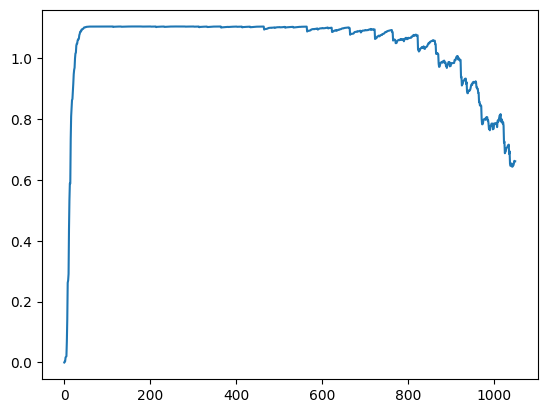

In [180]:
# plot the volution of W_a
plt.plot(w_A[:1050])

## SGD (symmetric and asymmetric)

In [ ]:
from torch.optim import Optimizer

class SGD_asym(Optimizer):
    
    def __init__(self, param_groups, lr=0.01, weight_decay=0.1):
        defaults = dict(lr=lr, weight_decay=weight_decay)
        super(SGD, self).__init__(param_groups, defaults)
        self.learning_rate_C = param_groups[0]['lr']
        self.weight_decay_C = param_groups[0]['weight_decay']
            

    def step(self):
        # Update each parameter
        for layer_C in self.param_groups[0]['params']:
            if layer_C.grad is None:
                continue

            layer_C.data += -self.learning_rate_C * (layer_C.grad + self.weight_decay_C * layer_C.data * torch.abs(layer_C.grad))

  

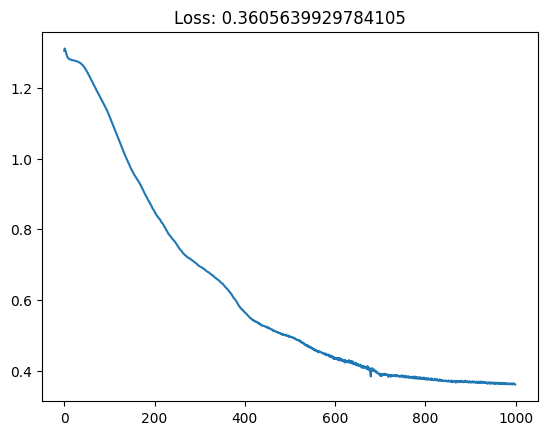

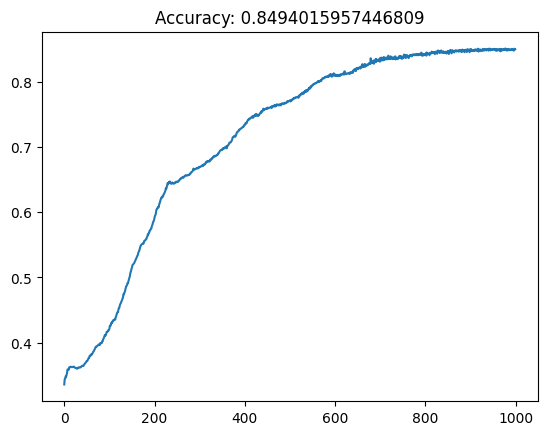

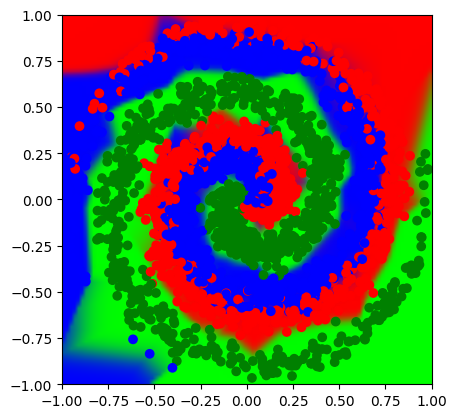

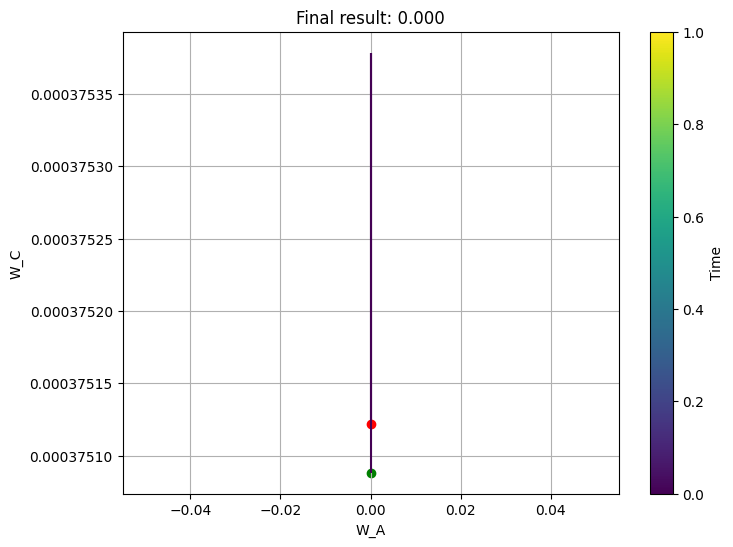

In [33]:
from torch.optim import SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

initial_weights_C_l1 = model.C.l1.weight.clone().detach()
initial_weights_C_l2 = model.C.l2.weight.clone().detach()

# optimizer = SGD_asym([
#     {'params': model.C.parameters(), 'lr': 0.0015, 'weight_decay': 0.2},
# ])

optimizer = SGD([
    {'params': model.C.parameters(), 'lr': 0.01, 'weight_decay': 0.0},
])


loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=64)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)

plot_evolution(w_C, w_A, window_size=10000)

In [34]:
results.append(model.C.l1.weight.data.numpy().tolist())

In [35]:
results

[[[0.19435133039951324, -0.2683524191379547],
  [1.1046388149261475, -2.621492385864258],
  [0.06487961858510971, 0.2732826769351959],
  [-0.821969747543335, -0.6651415228843689],
  [-1.5088289976119995, 0.15143577754497528],
  [-0.15061554312705994, -0.7936439514160156],
  [0.0006631623255088925, 1.1538680155354086e-05],
  [-1.2089802026748657, 0.44942328333854675],
  [-0.7309477925300598, 0.8647496700286865],
  [0.36655059456825256, 0.3963458836078644],
  [2.1184282302856445, 0.43763116002082825],
  [0.35770413279533386, 0.6371062397956848],
  [1.632689118385315, -0.31636038422584534],
  [0.11740374565124512, -0.16022562980651855],
  [-0.3423285186290741, -0.7047557830810547],
  [0.11129125952720642, -0.15749835968017578],
  [-0.002274380996823311, -0.0014172883238643408],
  [-1.227399468421936, -0.24085676670074463],
  [0.18182902038097382, 0.5583063960075378],
  [0.16522371768951416, -0.22503536939620972],
  [0.20061984658241272, -0.13921025395393372],
  [1.2789201736450195, 0.6655

In [36]:
# save results to a csv file
import csv

with open('SHD_script/training_weight_distribution_sgd.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(results)

## Adam (symmetric)

In [24]:
class C_A_Network_spiral(nn.Module):
    
    class Network(nn.Module):
        def __init__(self, zeroes=False, device='cpu'):
            super(C_A_Network_spiral.Network, self).__init__()
            self.l1 = nn.Linear(2, 64).to(device)
            self.l2 = nn.Linear(64, 32).to(device)
            self.l3 = nn.Linear(32, 8).to(device)
            self.l4 = nn.Linear(8, 3).to(device)

            if zeroes:
                self.l1.weight.data.fill_(0)
                self.l2.weight.data.fill_(0)
                self.l3.weight.data.fill_(0)
                self.l4.weight.data.fill_(0)
                for param in self.l1.parameters():
                    param.requires_grad = False
                for param in self.l2.parameters():
                    param.requires_grad = False
                for param in self.l3.parameters():
                    param.requires_grad = False
                for param in self.l4.parameters():
                    param.requires_grad = False
            
            else:
                self.l1.weight.data = torch.randn_like(self.l1.weight.data) * 0.01
                self.l2.weight.data = torch.randn_like(self.l2.weight.data) * 0.01
                self.l3.weight.data = torch.randn_like(self.l3.weight.data) * 0.01
                self.l4.weight.data = torch.randn_like(self.l4.weight.data) * 0.01

            self.l1.bias.data.fill_(0)
            self.l2.bias.data.fill_(0)
            self.l3.bias.data.fill_(0)
            self.l4.bias.data.fill_(0)
        
        def forward(self, x):
            x = torch.relu(self.l1(x)) #* 10
            x = torch.relu(self.l2(x))
            x = torch.relu(self.l3(x))
            x = self.l4(x)
            return x * 25


    def __init__(self, device='cpu'):
        super(C_A_Network_spiral, self).__init__()
        self.C = self.Network(zeroes=False, device=device)
        self.A = self.Network(zeroes=True, device=device)    

    def forward(self, x):
        return self.C(x)

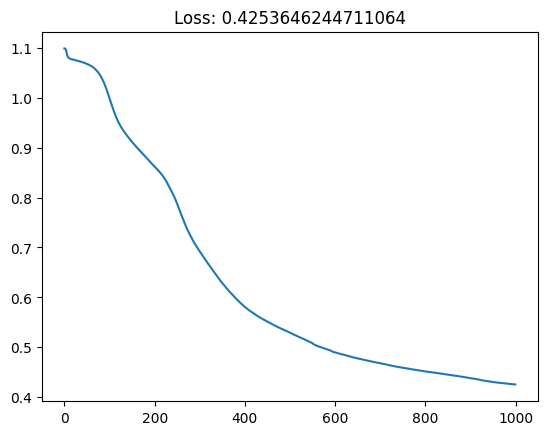

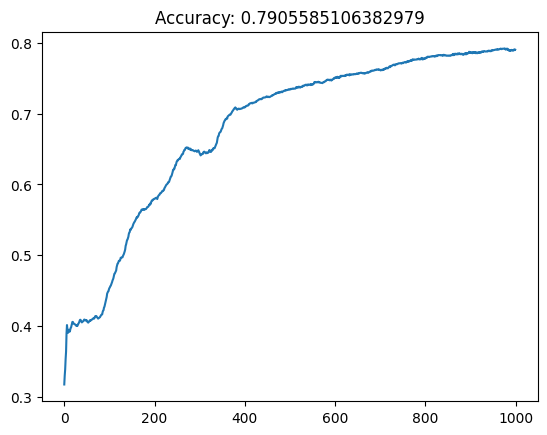

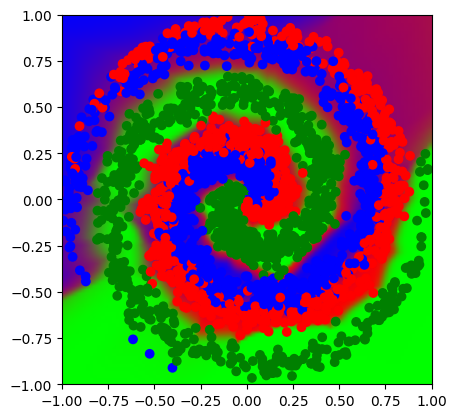

In [25]:
from torch.optim import AdamW

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
nnfs.init()
X_np, y_np = spiral_data(samples=1000, classes=3)
X = torch.tensor(X_np, dtype=torch.float32).to(device)
y = torch.tensor(y_np, dtype=torch.int64).to(device)
# shuffle data
indices = torch.randperm(len(X))
X = X[indices]
y = y[indices]

model = C_A_Network_spiral().to(device)

initial_weights_C_l1 = model.C.l1.weight.clone().detach()
initial_weights_C_l2 = model.C.l2.weight.clone().detach()

optimizer = AdamW([
    {'params': model.C.parameters(), 'lr': 0.0001},
])

loss_fn = nn.CrossEntropyLoss()

loss, accuracy, w_C, w_A = training_run(X, y, model, optimizer, loss_fn, 1000, batch_size=32)

plt.plot(loss)
plt.title(f'Loss: {loss[-1]}')
plt.show()

plt.plot(accuracy)
plt.title(f'Accuracy: {accuracy[-1]}')
plt.show()

num_points = 100
plot_prediction_performance(model, X, y, num_points, device)